In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.morphology import label
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "./input/stage1_train"]).decode("utf8"))
from multiprocessing import Pool
#print(check_output(["ls", "../input/stage1_train/"]).decode("utf8"))

In [2]:
#y_train = pd.read_csv('../input/stage1_train_labels.csv')
#print(y_train['EncodedPixels'])
#print(y_train.iloc[6]['EncodedPixels'])

In [3]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import os
from tqdm import tqdm
from skimage.transform import resize
%matplotlib inline

In [4]:
#print(os.listdir('./stage1_train')[1:])

In [5]:
image_heigth = 512
image_width = 512

mask_heigth = 512
mask_width = 512

# def get_masks(mask,masks_dir):
#     print("this is mask",mask)
#     masks = np.zeros((mask_heigth,mask_width))
#     mask_file = masks_dir + mask
#     mask = mpimg.imread(mask_file)
#     mask = resize(mask, (mask_heigth,mask_width), mode='constant', preserve_range=True)
#     masks = np.add(masks,mask)

#     return masks

def get_images_masks(root_dir):
    pyPool = Pool(2)
    images = []
    for image_folder in tqdm(os.listdir(root_dir)):
        image_id = image_folder
        image_dir = root_dir + image_folder
        image_file = image_dir + '/images/' + image_id + '.png'
        image = mpimg.imread(image_file)
        image = resize(image, (image_heigth, image_width), mode='constant', preserve_range=True)
        masks = np.zeros((mask_heigth,mask_width))
        masks_dir = image_dir + '/masks/'
        masks = np.zeros((mask_heigth,mask_width))
        #masks = pyPool.map(get_masks(,masks_dir), os.listdir(masks_dir))
        for mask in  os.listdir(masks_dir):
            mask_file = masks_dir + mask
            mask = mpimg.imread(mask_file)
            mask = resize(mask, (mask_heigth,mask_width), mode='constant', preserve_range=True)
            masks = np.add(masks,mask)

            
        
        images.append({'image_id': image_id, 'image': image,'masks': masks })
        
    return images

def plot_images(rows,cols,images):
    image_index = 0
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30), squeeze=False)
    for r in range(rows):
        for c in range(cols):
            ax[r][c].imshow(images[image_index])
            image_index += 1

In [6]:
images = get_images_masks("./input/stage1_train/")

100%|██████████| 670/670 [05:26<00:00,  2.05it/s]


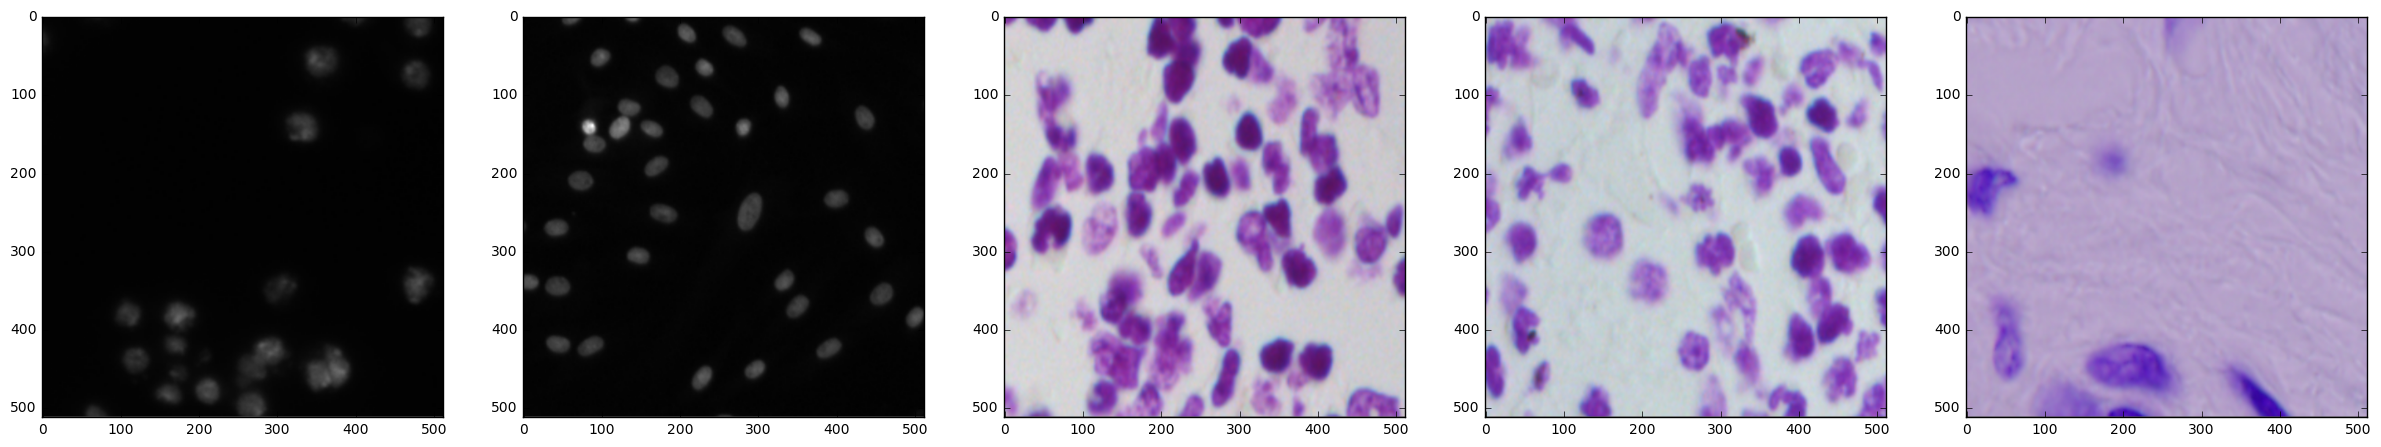

In [7]:
images_array = [image['image'] for image in images]
plot_images(rows=1,cols=5,images=images_array)

In [8]:
X_train = np.array(images_array).reshape(670,image_heigth,image_width,4)
print(X_train.shape)

(670, 512, 512, 4)


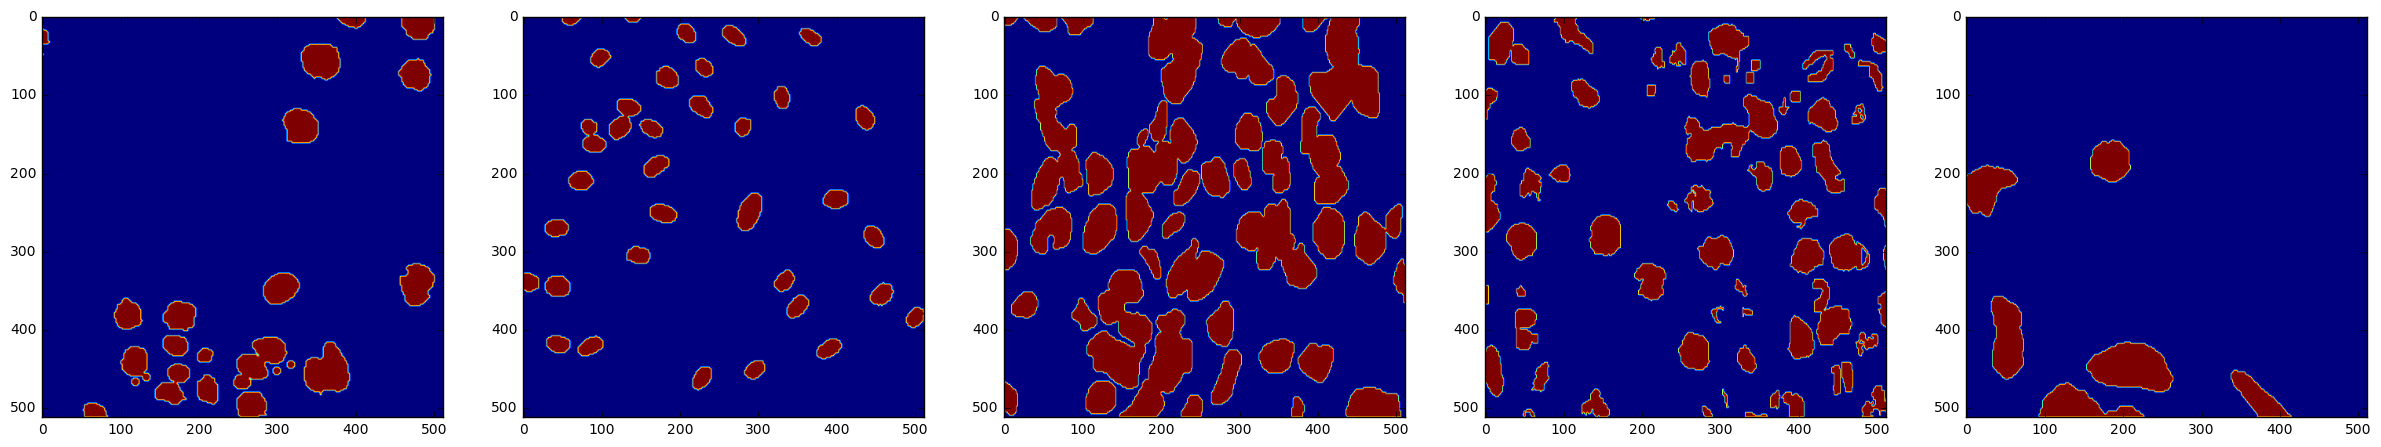

In [9]:
masks_array = [image['masks'] for image in images]
plot_images(rows=1,cols=5,images=masks_array)

In [10]:
Y_train = np.array(masks_array).reshape(670,mask_heigth,mask_width,1)
print(Y_train.shape)

(670, 512, 512, 1)


In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import SGD, Adam
import tensorflow as tf

Using TensorFlow backend.


In [12]:
def model_create(height,width,channels,filter_init):
    X_Input = Input(shape=(height,width,channels))
    print(filter_init,filter_init*2,filter_init*4,filter_init*8,filter_init*16,filter_init*32,filter_init)
    
    X = Conv2D(filters=filter_init, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X_Input)
    #X = Dropout(0.25)(X)
    CX1 = Conv2D(filters=filter_init, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)    
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX1)
    X = Conv2D(filters=filter_init*2, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)    
    #X = Dropout(0.25)(X)
    CX2 = Conv2D(filters=filter_init*2, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)  
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX2)    
    X = Conv2D(filters=filter_init*4, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    CX3 = Conv2D(filters=filter_init*4, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)   
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX3)    
    X = Conv2D(filters=filter_init*8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    CX4 = Conv2D(filters=filter_init*8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X) 
    #X = BatchNormalization()(X)
    
    
#     X = MaxPooling2D(pool_size=(2,2), strides=2)(CX4)    
#     X = Conv2D(filters=filter_init*16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
#     #X = Dropout(0.25)(X)
#     CX5 = Conv2D(filters=filter_init*16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)   
#     #X = BatchNormalization()(X)
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX4)    
    X = Conv2D(filters=filter_init*16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Dropout(0.25)(X)
    X = Conv2D(filters=filter_init*16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)   
    #X = BatchNormalization()(X)
    
#     X = Conv2DTranspose(filters=filter_init*16, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
#     X = concatenate([X,CX5])
#     X = Conv2D(filters=filter_init*16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
#     X = Conv2D(filters=filter_init*16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
#     #X = Dropout(0.25)(X)
#     #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=filter_init*8, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX4])
    X = Conv2D(filters=filter_init*8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=filter_init*8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=filter_init*4, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX3])
    X = Conv2D(filters=filter_init*4, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=filter_init*4, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=filter_init*2, kernel_size=(2,2), strides=(2,2),activation='relu', kernel_initializer='he_normal')(X)
    X = concatenate([X,CX2])
    X = Conv2D(filters=filter_init*2, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=filter_init*2, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=filter_init, kernel_size=(2,2), strides=(2,2),activation='relu', kernel_initializer='he_normal')(X)
    X = concatenate([X,CX1])
    X = Conv2D(filters=filter_init, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=filter_init, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.1)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2D(filters=1, kernel_size=(3,3),activation='sigmoid', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    
    model_ = Model(input=X_Input, output=X)
    model_.summary()
    
    return model_

In [13]:
model = model_create(image_heigth,image_width,4,16)

(16, 32, 64, 128, 256, 512, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_2[0][0]                   
_____________________________________________________________________________

/Users/lfawaz/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [14]:
for i in range(1):
    r = -5 * np.random.rand()
    lr = 0.001#10 ** r
    print("learning rate: ", lr)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=optimizer,loss='binary_crossentropy')
    earlystopper = EarlyStopping(patience=5, verbose=1)
    csv_logger = CSVLogger('dsBowlTraining_noBN_lr_' + str(lr) + '_decay_' + str(1) + '.csv')
    model_name = 'dsBowlModel_noBN_lr_' + str(lr) + '_decay_' + str(0) + '.h5'
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=200, 
                        callbacks=[checkpointer, earlystopper, csv_logger])

('learning rate: ', 0.001)
Train on 603 samples, validate on 67 samples
Epoch 1/200
576/603 [===========================>..] - ETA: 1:25 - loss: 0.4889
Epoch 00001: val_loss improved from inf to 0.36934, saving model to dsBowlModel_noBN_lr_0.001_decay_0.h5
603/603 [==============================] - 2004s 3s/step - loss: 0.4827 - val_loss: 0.3693
Epoch 2/200
576/603 [===========================>..] - ETA: 1:26 - loss: 0.3633
Epoch 00002: val_loss improved from 0.36934 to 0.28615, saving model to dsBowlModel_noBN_lr_0.001_decay_0.h5
603/603 [==============================] - 2013s 3s/step - loss: 0.3598 - val_loss: 0.2862
Epoch 3/200
576/603 [===========================>..] - ETA: 1:26 - loss: 0.2501
Epoch 00003: val_loss improved from 0.28615 to 0.18924, saving model to dsBowlModel_noBN_lr_0.001_decay_0.h5
603/603 [==============================] - 2026s 3s/step - loss: 0.2460 - val_loss: 0.1892
Epoch 4/200
576/603 [===========================>..] - ETA: 1:27 - loss: 0.1997
Epoch 00004:

In [15]:
model_path = './' + model_name
print(model_path)

./dsBowlModel_noBN_lr_0.001_decay_0.h5


In [16]:

results = load_model(model_path)

In [17]:
Y_train_pred = results.predict(X_train,verbose=1)

670/670 [==============================] - 929s 1s/step


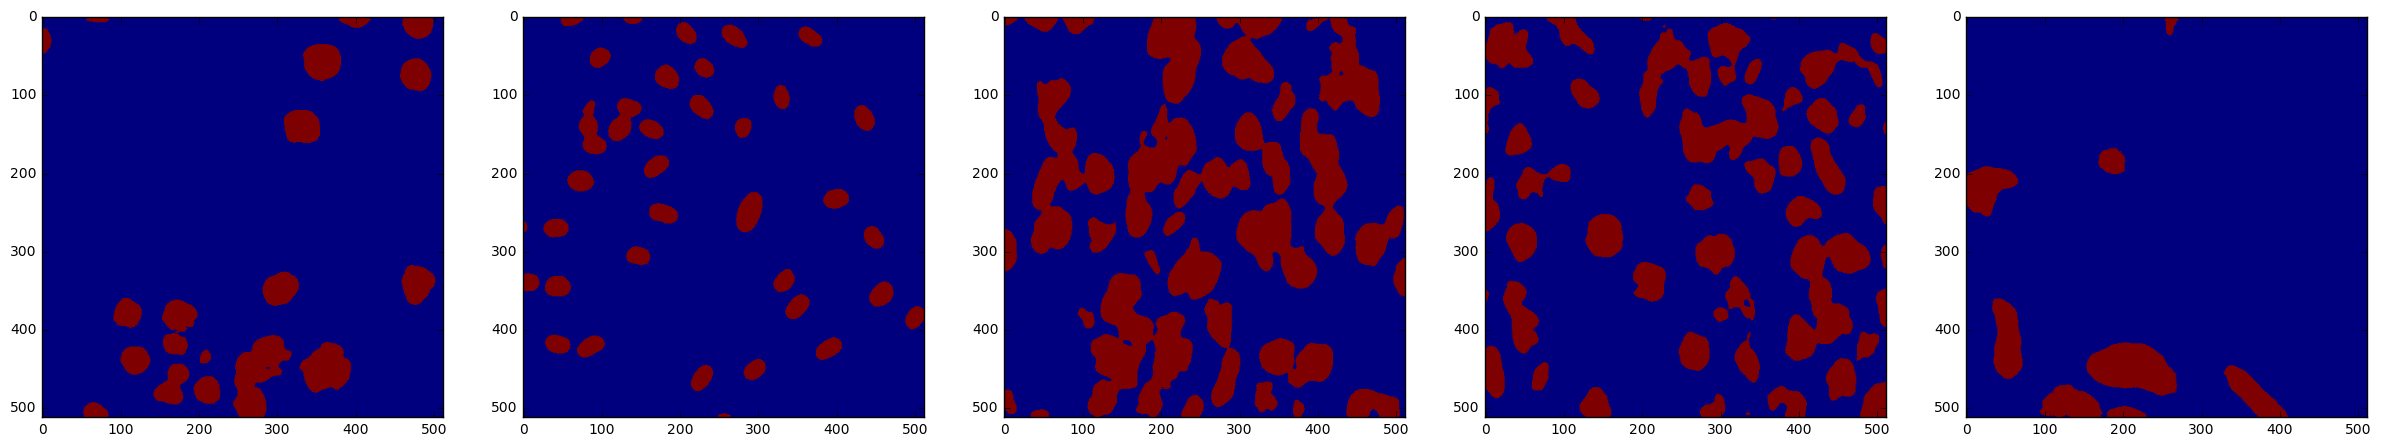

In [18]:
Y_train_pred = (Y_train_pred.reshape(670,mask_heigth,mask_width) > 0.5).astype(int)
plot_images(rows=1,cols=5,images=Y_train_pred)

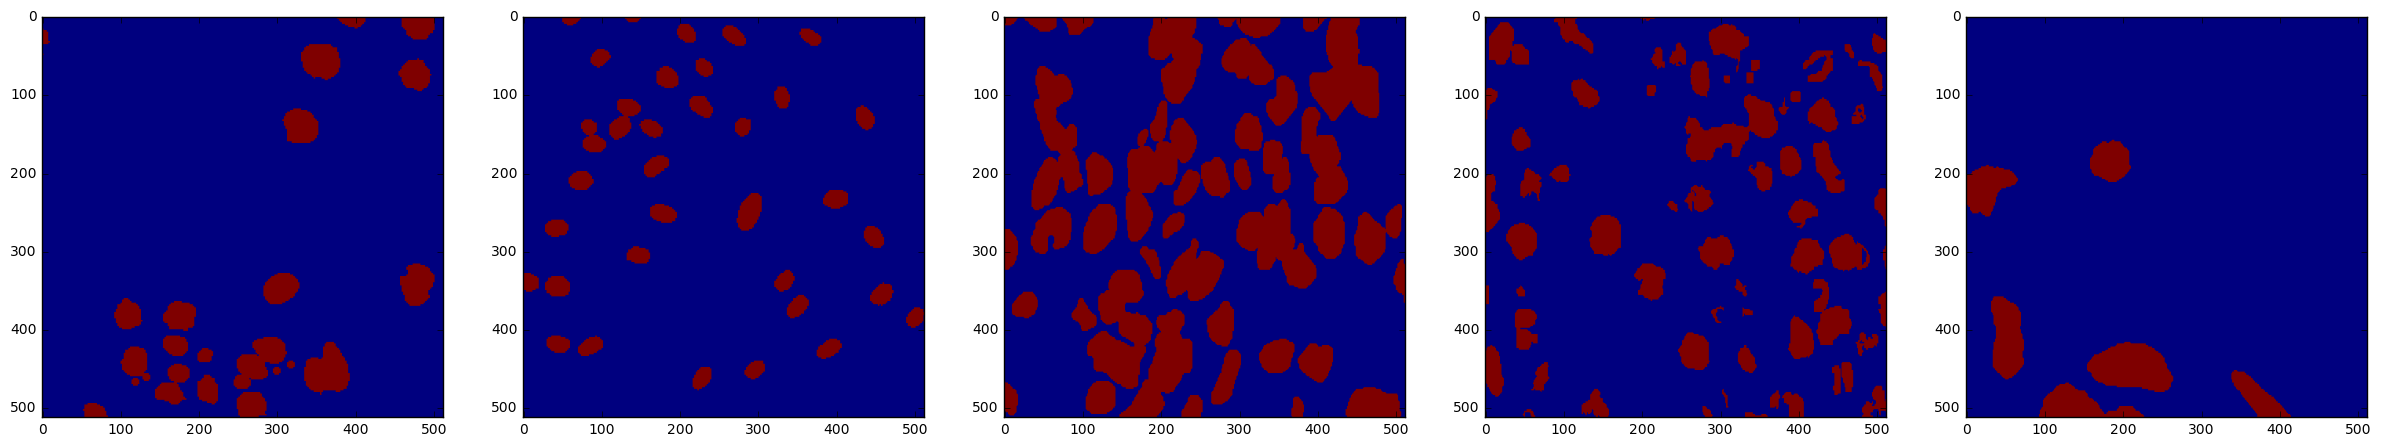

In [19]:
Y_train_true = (Y_train.reshape(670,mask_heigth,mask_width) > 0.5).astype(int)
plot_images(rows=1,cols=5,images=Y_train_true)

In [20]:
from scipy import ndimage
from sklearn.metrics import hamming_loss

In [21]:
def calculate_pixel_error(y_true, y_pred):
    n = len(y_true)
    errors = []
    for i in range(n):
        error = hamming_loss(y_true[i].flatten(),y_pred[i].flatten())
        errors.append(error)

    pixel_error = np.sum(errors)/n
    
    return pixel_error

In [22]:
print "Traing Pixel Error:", calculate_pixel_error(Y_train_true,Y_train_pred)


Traing Pixel Error: 0.0294265519327


In [23]:
def separate_masks(combined_masks):
    labeled_masks = label(combined_masks)
    masks = []
    for i in range(1,np.max(labeled_masks)+1):
        mask = (labeled_masks == i).astype(int)
        masks.append(mask)
    
    return masks

# def separate_masks(combined_masks):
#     labeled_masks = ndimage.label(combined_masks)
#     masks = []
#     for i in range(1,labeled_masks[1]+1):
#         mask = (labeled_masks[0] == i).astype(int)
#         masks.append(mask)
    
#     return masks


def identify_postive_pixels(mask):

    return list(np.argwhere(mask.T.flatten()>0)[:,0])


def encode_postive_pixels(postive_pixels):
    EncodedPixels = []
    for i in range(len(postive_pixels)):
        if(postive_pixels[i] - 1 in postive_pixels):
            EncodedPixels[-1][1] += 1


        else:                 
            EncodedPixels.append([postive_pixels[i]+1,1])
            
    encodedPixels = ''    
    for item in EncodedPixels:
        for i in item:
            encodedPixels = encodedPixels + str(i) + ' '
           

    return encodedPixels

def create_submission_dataFrame(test_images,resized_masks):
    submission = []
    for index in tqdm(range(len(test_images))):
        image_id = test_images[index]['image_id']
        masks = separate_masks(resized_masks[index])
        for j in range(len(masks)):
            postive_pixels = identify_postive_pixels(masks[j])
            encoded_pixels = encode_postive_pixels(postive_pixels)
            submission.append([image_id, encoded_pixels])
    return pd.DataFrame(np.array(submission),columns=['ImageId','EncodedPixels'])

In [24]:
def get_test_images(root_dir,model):
    images = []
    for image_folder in tqdm(os.listdir(root_dir)):
        image_id = image_folder
        image_dir = root_dir + image_folder
        image_file = image_dir + '/images/' + image_id + '.png'
        
        image = mpimg.imread(image_file) 
        images.append({'image_id': image_id, 'image': image })
    
    return images

In [25]:
test_images = get_test_images('./input/stage1_test/','a')

100%|██████████| 65/65 [00:00<00:00, 90.10it/s]


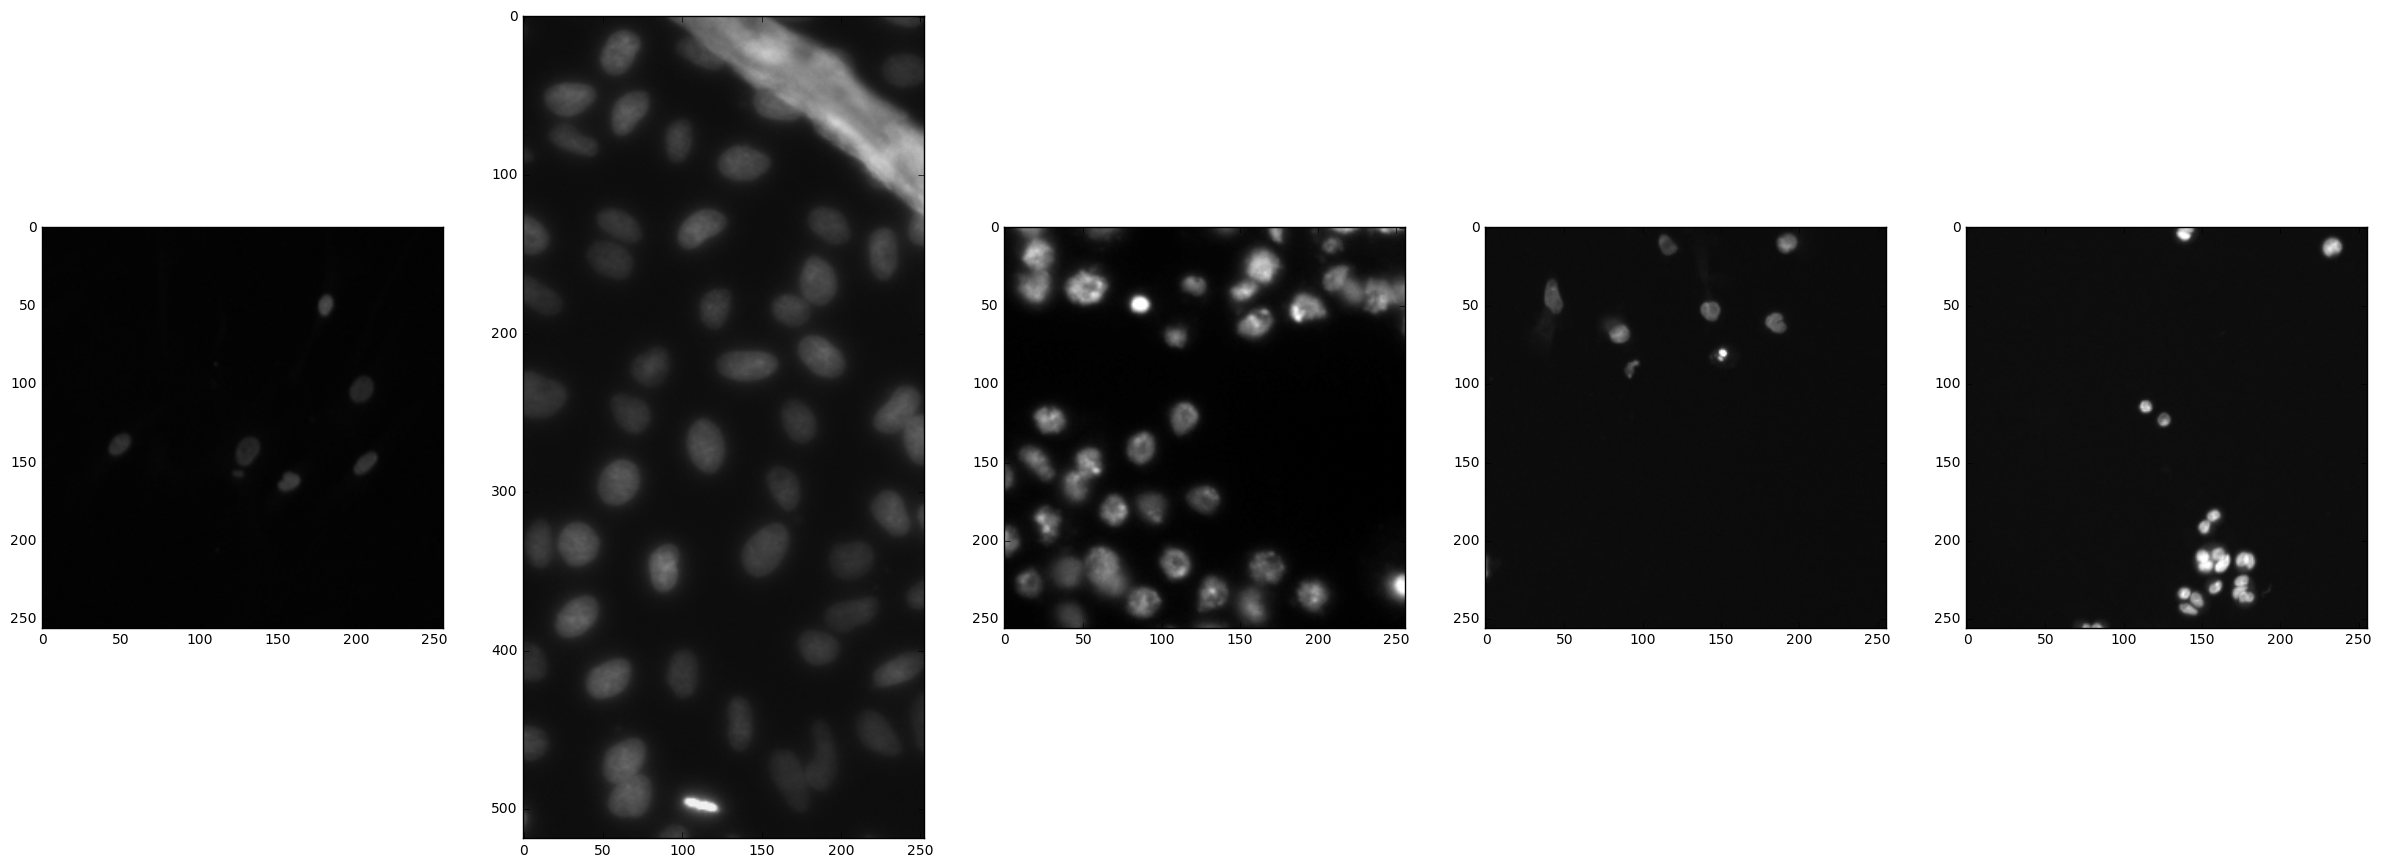

In [26]:
test_images_array = [image['image'] for image in test_images]
plot_images(rows=1,cols=5,images=test_images_array)

In [27]:
def create_predicted_masks(images_array,model):
    X_test = []
    for image in images_array:      
        image = resize(image, (image_heigth, image_width, 4), mode='constant', preserve_range=True)
        X_test.append(image)
    
    X_test = np.array(X_test).reshape(65,mask_heigth,mask_width,4)
    Y_test_pred = model.predict(X_test,verbose=1)
    Y_test_pred = (Y_test_pred.reshape(65,mask_heigth,mask_width) > 0.5).astype(int)
    return Y_test_pred

In [28]:
test_masks = create_predicted_masks(test_images_array,results)

65/65 [==============================] - 99s 2s/step


In [29]:
def resize_image_masks(images_array,masks):
    i = 0
    org_masks = []
    for i in range(len(masks)):
        heigth, width = (images_array[i].shape[0], images_array[i].shape[1])
        mask = resize(masks[i], (heigth, width), mode='constant', preserve_range=True).astype(int)
        org_masks.append(mask)
        
    return org_masks

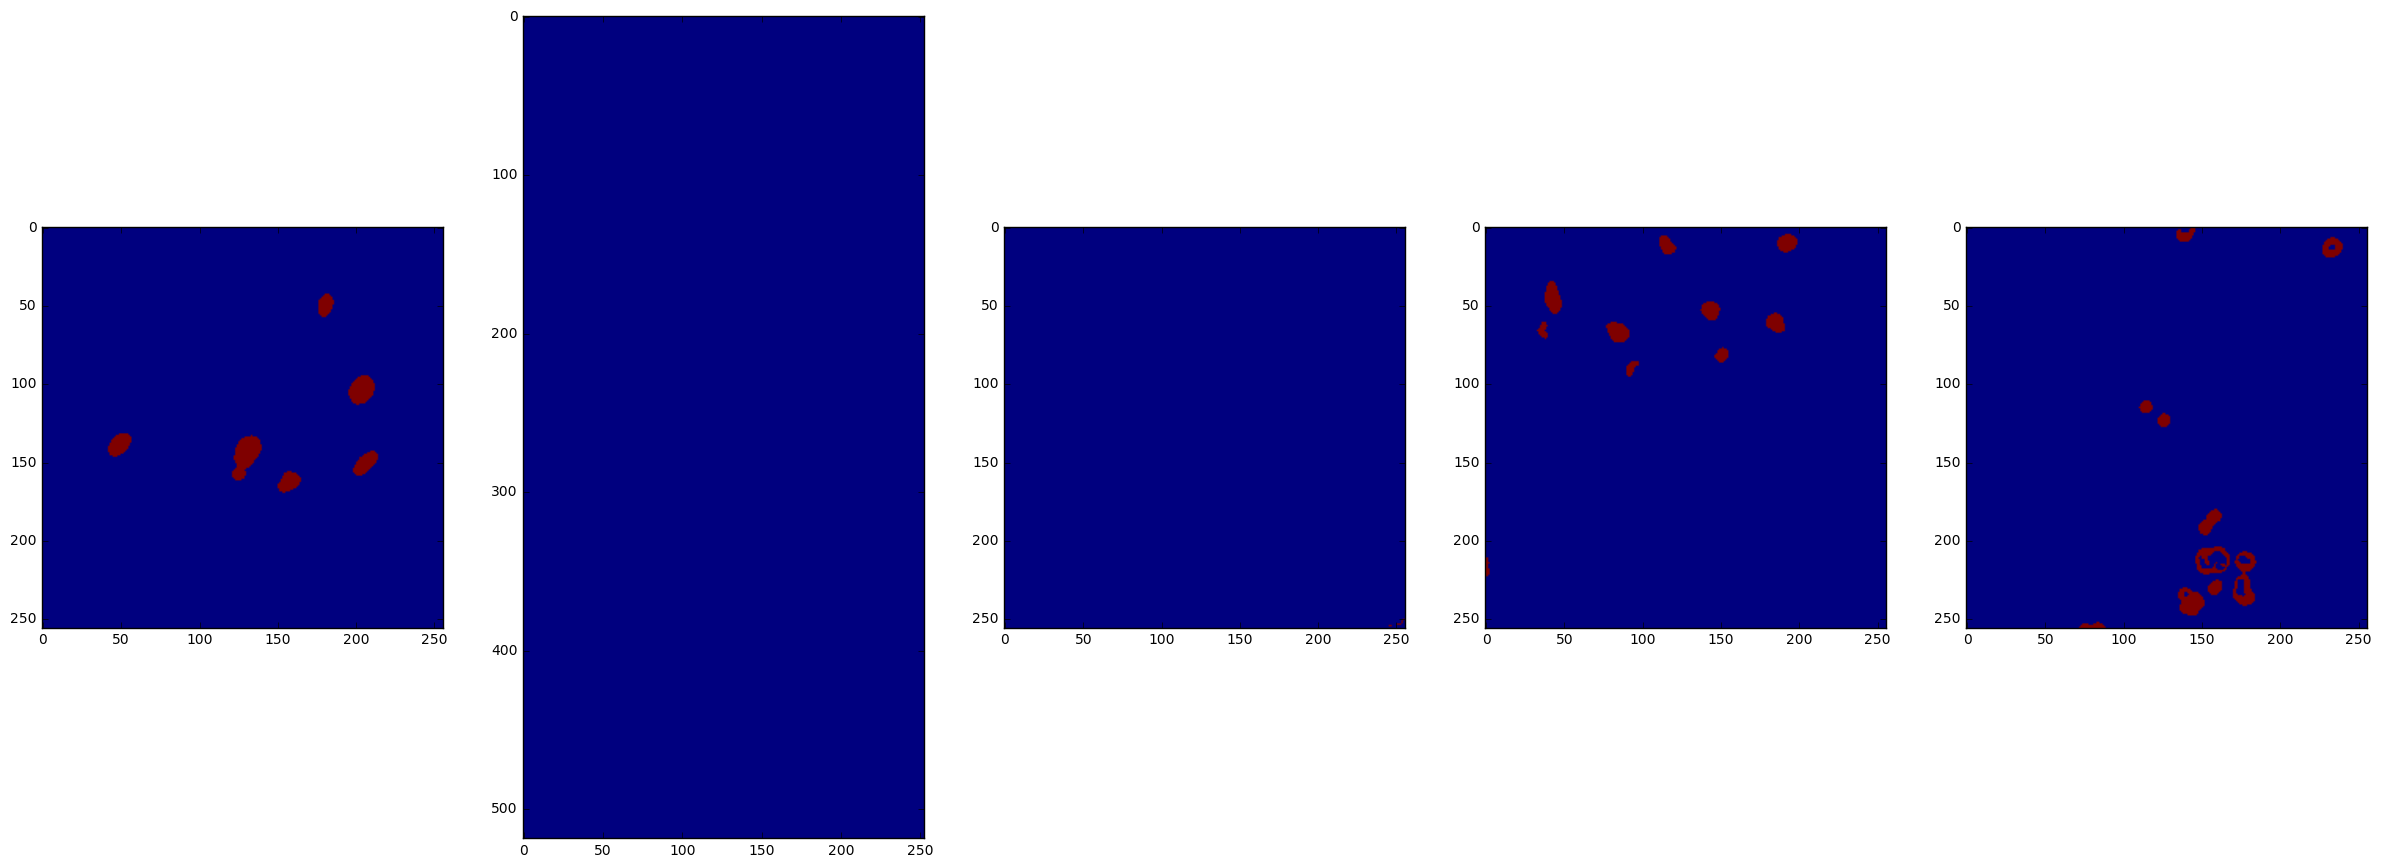

In [30]:
resized_masks = resize_image_masks(test_images_array, test_masks)
plot_images(rows=1,cols=5,images=resized_masks)

In [31]:
stage1_test = create_submission_dataFrame(test_images,resized_masks)

100%|██████████| 65/65 [00:17<00:00,  3.73it/s]


In [32]:
stage1_test.to_csv('stage1_test_labels.csv',index=False)

In [33]:
test_ids = [test_image['image_id'] for test_image in test_images]
preds_test_upsampled = resized_masks

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('stage1_test_labels_stolen.csv', index=False)